# Convolution Neural Network Case Study

**Alex Damisch | May 2025**

This notebook demonstrates Convolution Neural Networks on the [EuroSAT Dataset](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset). The EuroSAT dataset consists of 27,000 64x64 images belonging to 10 classes of land (and water) use. Examples of the classes include `Forest`, `Highway`, `Pasture`, and `River`.

Here I use a convolutional neural network in tensorflow, a common neural network and library choice for classifying image datasets.

Because this notebook was adapted from my work with Flatiron School, I chose to keep it notebook a bit "organic" or didactic, with lots of comments and multiple attempts until I found the right fit for this dataset.

In [1]:
import os

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical


2025-10-20 13:19:56.802687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download the dataset
downloaded_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

In [3]:
data_dir = os.path.join(downloaded_path, "EuroSAT")


In [4]:
# Load the dataset
batch_size = 32
img_size = (64, 64)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [6]:
# Get class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize pixel values and one-hot encode labels
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, num_classes)))

## First Attempt

In [7]:
# Define the CNN model

model = tf.keras.models.Sequential([
    #Captures small patterns in early layers (edges, textures)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # Reduces spatial dimensions -> fewer parameters & faster training
    #Standard size that retains most relevant features while downsampling
    # Con: definitely increased training time for me
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #Deeper features (shape, object boundaries)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #High-level, abstract features (class-level patterns)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten + Dense Layers
    # Flatten: Converts 3D feature maps to 1D vector for classification
    layers.Flatten(),
    # Dense: Learns global patterns from convolutional features
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    # Dropout: Prevents overfitting (especially on small datasets)
    layers.Dropout(0.5),

    # Output layer
    # One neuron per class (EuroSAT has 10 classes)
    # Softmax activation: Produces a probability distribution over classes
    layers.Dense(10, activation='softmax')  # 10 classes in EuroSAT
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)



Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 96s 142ms/step - accuracy: 0.9327 - loss: 0.1955 - val_accuracy: 0.7194 - val_loss: 0.9803
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 98s 145ms/step - accuracy: 0.9394 - loss: 0.1845 - val_accuracy: 0.6583 - val_loss: 1.3767
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 97s 144ms/step - accuracy: 0.9467 - loss: 0.1623 - val_accuracy: 0.7354 - val_loss: 0.9204
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 97s 143ms/step - accuracy: 0.9496 - loss: 0.1496 - val_accuracy: 0.4987 - val_loss: 3.0810
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 147ms/step - accuracy: 0.9428 - loss: 0.1639 - val_accuracy: 0.8093 - val_loss: 0.6348
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 98s 145ms/step - accuracy: 0.9617 - loss: 0.1192 - val_accuracy: 0.7943 - val_loss: 0.7248
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 146ms/step - accuracy: 0.9589 - loss: 0.1236 - val_accuracy: 0.5870 - val_loss: 2.9484
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 148ms/step - accuracy: 0.9623 - loss:

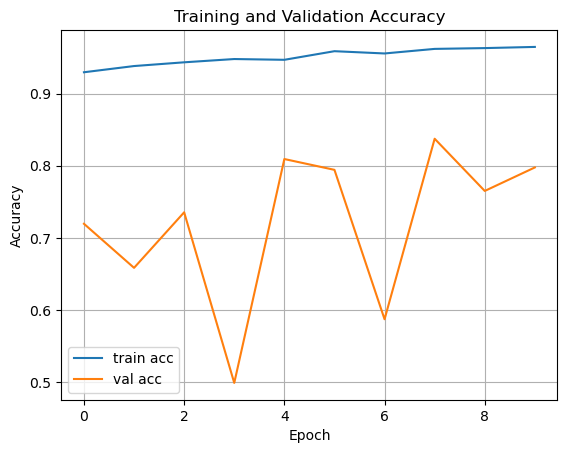

In [10]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')
plt.show()

Our first attempt at training does not look very good at all! Since our training accuracy is high but our validation accuracy is low, we assume that we're overfitting (as opposed to low training accuracy as well, which might indicate underfitting).

## Second Attempt

In [11]:
# This model adds dropouts after each layer, which should help address overfitting
# I also use a regularizer to help penalize the model
# And an earlystopping callback

model =  tf.keras.models.Sequential([
    # Small patterns in early layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4), input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Deeper features
    layers.Conv2D(48, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # High-level, abstract features
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.55),

    # Flatten + dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(10, activation='softmax')
])


In [12]:
model.compile(
    optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use EarlyStopping with patience of 3 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [13]:
# Train model with EarlyStopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,            
    callbacks=[early_stop]
)

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 160ms/step - accuracy: 0.4701 - loss: 1.6742 - val_accuracy: 0.3209 - val_loss: 2.6293
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 106s 157ms/step - accuracy: 0.6960 - loss: 0.9200 - val_accuracy: 0.6611 - val_loss: 1.0214
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 107s 158ms/step - accuracy: 0.7572 - loss: 0.7706 - val_accuracy: 0.6161 - val_loss: 1.1984
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 104s 155ms/step - accuracy: 0.7742 - loss: 0.7106 - val_accuracy: 0.6369 - val_loss: 1.1978
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 108s 160ms/step - accuracy: 0.7958 - loss: 0.6791 - val_accuracy: 0.6191 - val_loss: 1.3031


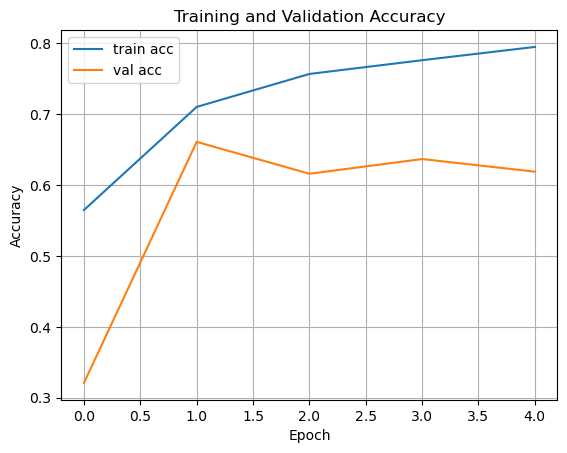

In [14]:
# Note that training time per step was pretty comparable to the first attempt

# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')
plt.show()

This model still has the same overfitting issues as the first one!

## Third Attempt: Pretrained model

Although this case study was originally supposed to teach students about building their own custom CNNs, in the "real world" we may prefer to use a pre-trained model. EfficientNet is a family of pre-trained CNN models from Google that is conveniently offered in tensorflow.

### Undo preprocessing

In [15]:
# In previous attempts we noramlized the pixel values
# and scaled down
# but efficientnet expects [0, 255] so we scaled back up

def undo_scaling(ds):
    return ds.map(lambda x, y: (preprocess_input(x * 255.0), y))  # undo previous 1./255 scaling

train_ds_2 = undo_scaling(train_ds)
val_ds_2 = undo_scaling(val_ds)


### Build from pretrained model

In [16]:
# Load EfficientNetB0
# include_top=False: remove original classification layer
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(64, 64, 3)
)

# Freeze pretrained layers
base_model.trainable = False

In [17]:
# We don't technically need to use a Sequential statement here 
# Because we're just using a single, pre-trained model
# But I like it for the purposes of continuity with our previous attempts

model = models.Sequential([
    # Preprocessing must be done outside if using one-hot labels
    # EfficientNetB0 base model (frozen)
    base_model,
    
    # Collapses spatial dimensions to a single vector
    layers.GlobalAveragePooling2D(),
    
    # Dense layer to learn high-level patterns
    layers.Dense(128, activation='relu'),
    
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(10, activation='softmax')
])

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


# Same early stopping patience of 3 as before
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce learning rate when model stops improving
# Helps for faster convergence
# Recommended for transfer learning like we're doing from the pretrained model
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5)

# Why use both?
# Lowering LR rate slows down learning to improve the performance
# Earlystopping stops training when further improvement is unlikely
# LR patience is lower than earlystopping patience
# So we try to reduce learning rate first, then stop if necessary

In [19]:
history = model.fit(
    train_ds_2,
    validation_data=val_ds_2,
    epochs=20,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 107s 145ms/step - accuracy: 0.7516 - loss: 0.7759 - val_accuracy: 0.9056 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.8834 - loss: 0.3544 - val_accuracy: 0.9152 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 113s 168ms/step - accuracy: 0.8935 - loss: 0.3130 - val_accuracy: 0.9189 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 96s 142ms/step - accuracy: 0.9044 - loss: 0.2791 - val_accuracy: 0.9200 - val_loss: 0.2347 - learning_rate: 0.0010
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 102s 152ms/step - accuracy: 0.9092 - loss: 0.2720 - val_accuracy: 0.9246 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.9172 - loss: 0.2428 - val_accuracy: 0.9244 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 106s 156ms/step - accuracy:

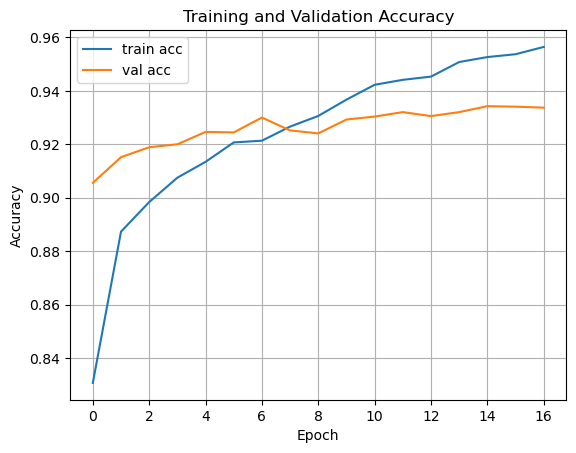

In [24]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')
plt.show()

Wow! Using the pre-trained model shows enormous improvement, with both training and validation accuracy over 0.92. 

## Evaluation

In [25]:
class_names = [
    "Annual Crop", "Forest", "Herbaceous Veg", "Highway", "Industrial",
    "Pasture", "Permanent Crop", "Residential", "River", "Sea/Lake"
]

# Gather predictions and true labels
true_labels = []
pred_labels = []

for images, labels in val_ds_2:
    preds = model.predict(images, verbose=0)
    
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        true_cls = np.argmax(labels.numpy(), axis=1)
    else:
        true_cls = labels.numpy()
    
    pred_cls = np.argmax(preds, axis=1)
    
    true_labels.extend(true_cls)
    pred_labels.extend(pred_cls)

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)



2025-10-20 14:32:50.709269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Confusion Matrix Visualization

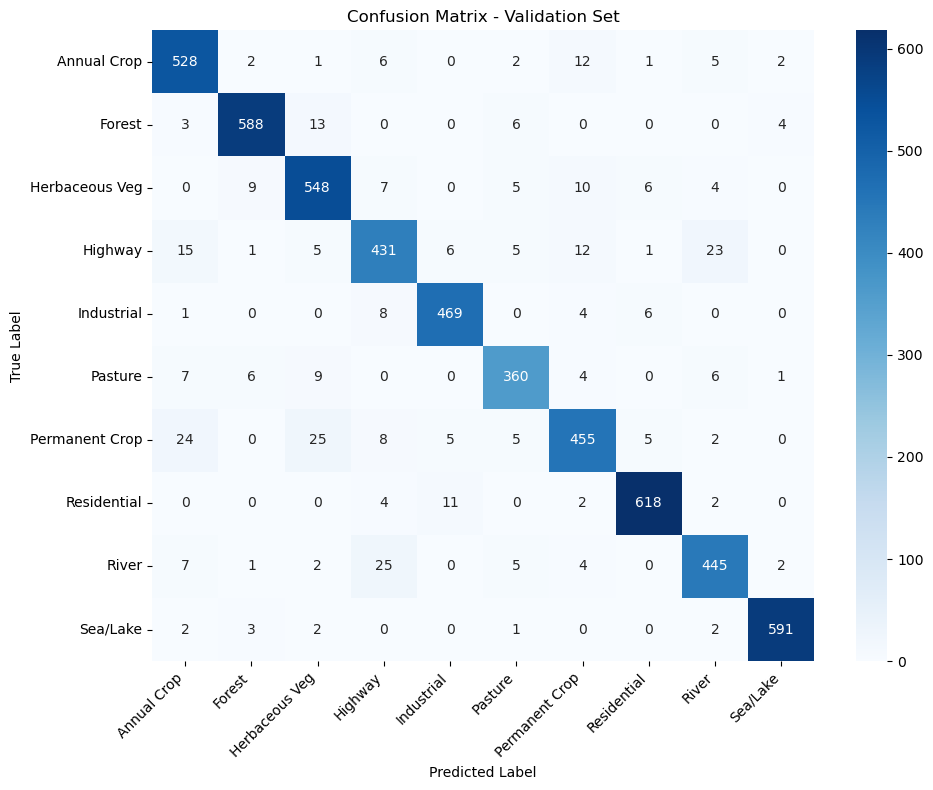

In [26]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Classification Report

In [27]:
# Generate and print the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                precision    recall  f1-score   support

   Annual Crop       0.90      0.94      0.92       559
        Forest       0.96      0.96      0.96       614
Herbaceous Veg       0.91      0.93      0.92       589
       Highway       0.88      0.86      0.87       499
    Industrial       0.96      0.96      0.96       488
       Pasture       0.93      0.92      0.92       393
Permanent Crop       0.90      0.86      0.88       529
   Residential       0.97      0.97      0.97       637
         River       0.91      0.91      0.91       491
      Sea/Lake       0.98      0.98      0.98       601

      accuracy                           0.93      5400
     macro avg       0.93      0.93      0.93      5400
  weighted avg       0.93      0.93      0.93      5400



## Predicted and actual class for 5 examples

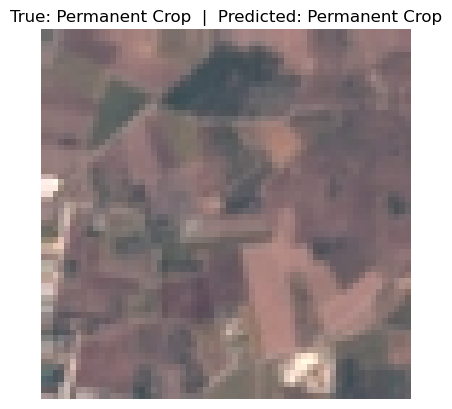

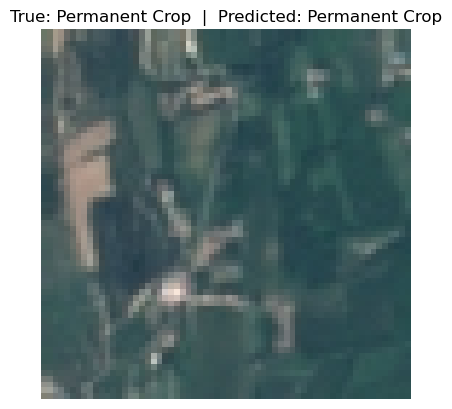

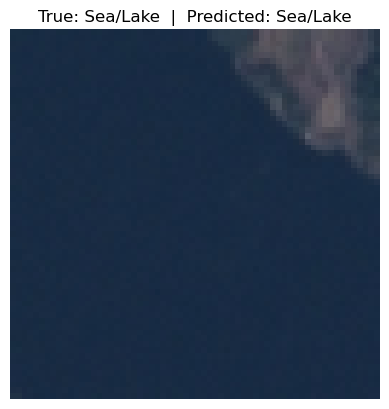

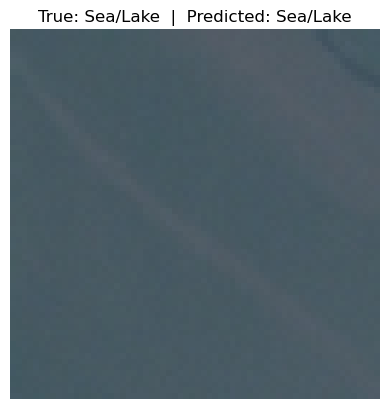

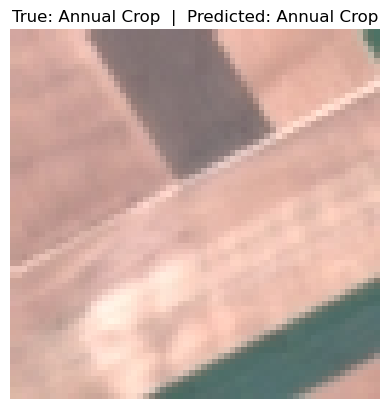

In [32]:
# Get first 5 images in validation data to show 
# Going back to the original dataset, val_ds, for plotting
# It's normalized but not scaled like val_ds_2 is
# the imshow function is expecting something more like val_ds
# But we'll still have to preprocess the im

# Take the first batch from validation set
for images, labels in val_ds.take(1):
    for i in range(5): 
        # Original image for plotting (still in [0,1])
        img_plot = images[i].numpy()
        
        # True label (convert from one-hot to integer)
        true_label = np.argmax(labels[i].numpy())
        
        # EfficientNet expects unscaled data
        img_model = preprocess_input(img_plot * 255.0)
        img_model_exp = np.expand_dims(img_model, axis=0)
        
        # Predict
        preds = model.predict(img_model_exp, verbose=0)
        pred_label = np.argmax(preds[0])
        
        # Plot
        plt.imshow(img_plot)
        plt.axis('off')
        plt.title(f"True: {class_names[true_label]}  |  Predicted: {class_names[pred_label]}")
        plt.show()
    
    break